In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from eikonax import corefunctions, derivator, logging, preprocessing, solver, tensorfield

sns.set_theme(style="ticks")
jax.config.update("jax_enable_x64", False)

In [10]:
disable_jit = False
log_compiles = False
mesh_bounds_x = (-1, 1)
mesh_bounds_y = (-1, 1)
num_points_x = 10
num_points_y = 10
dimension = 2

solver_data = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    loop_type="jitted_while",
    max_value=1000,
    use_soft_update=False,
    softminmax_order=20,
    softminmax_cutoff=1,
    log_interval=1,
)

derivator_data = derivator.PartialDerivatorData(
    softmin_order=20,
    softminmax_order=20,
    softminmax_cutoff=1,
)

logger_data = logging.LoggerSettings(
    log_to_console=True,
    logfile_path=None,
)

initial_sites = corefunctions.InitialSites(inds=jnp.array((0,)), values=jnp.array((0,)))

In [11]:
vertices, simplices = preprocessing.create_test_mesh(
    mesh_bounds_x, mesh_bounds_y, num_points_x, num_points_y
)
adjacency_data = preprocessing.get_adjacent_vertex_data(simplices, vertices.shape[0])
mesh_data = corefunctions.MeshData(vertices=vertices, adjacency_data=adjacency_data)

parameter_vector = jnp.ones(simplices.shape[0], dtype=jnp.float32)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_on_simplex = tensorfield.LinearScalarSimplexTensor(dimension)
tensor_field = tensorfield.TensorField(simplices.shape[0], tensor_field_mapping, tensor_on_simplex)
logger = logging.Logger(logger_data)

In [13]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    parameter_field = tensor_field.assemble_field(parameter_vector)
    eikonal_solver = solver.Solver(mesh_data, solver_data, initial_sites, logger)
    solution = eikonal_solver.run(parameter_field)

In [5]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    eikonax_derivator = derivator.PartialDerivator(mesh_data, derivator_data, initial_sites)
    sparse_partial_solution, sparse_partial_tensor = eikonax_derivator.compute_partial_derivatives(
        solution.values, parameter_field
    )
    derivative_solver = derivator.DerivativeSolver(solution.values, sparse_partial_solution)
    sparse_partial_parameter = tensor_field.assemble_jacobian(
        num_points_x*num_points_y, sparse_partial_tensor, parameter_vector
    )

In [14]:
jnp.max(solution.values)

Array(2.900946, dtype=float32)

In [7]:
rhs_adjoint_equation = np.ones(solution.values.shape, dtype=jnp.float32)
adjoint_variable = derivative_solver.solve(rhs_adjoint_equation)
gradient = sparse_partial_parameter.T @ adjoint_variable

In [8]:
gradient

array([-10.99999933,  -0.07856742,  -0.1111111 ,  -0.11111117,
        -3.04365557,  -3.93290591,  -0.77813929,  -1.47771454,
        -0.55583764,  -0.18509614,  -2.84439758,  -0.6669487 ,
        -0.1111111 ,  -0.11111117,  -0.22235225,  -0.11104608,
         0.        ,  -0.05555556,  -2.31371518,  -0.83600064,
        -0.07856742,   0.        ,  -3.24125628,  -4.13046439,
        -0.77809705,  -1.37886522,   0.        ,  -0.07856743,
        -2.55226062,  -1.1733954 ,   0.        ,  -0.05555556,
        -2.64669331,  -0.66691195,  -0.12954108,  -0.12954108,
        -0.10548789,  -0.20270953,  -0.63958222,  -0.69513778,
        -1.54007702,  -1.9102693 ,   0.        ,  -0.08160385,
        -0.22221571,  -0.22208865,  -1.31915472,  -1.09693901,
        -0.16666015,  -0.2582651 ,  -0.56060618,  -0.30234109,
        -0.07856742,  -0.07856742,  -0.05555555,  -0.16666578,
         0.        ,  -0.07856743,  -1.0325326 ,  -0.97697705,
        -1.40024195,  -1.6779124 ,   0.        ,  -0.08

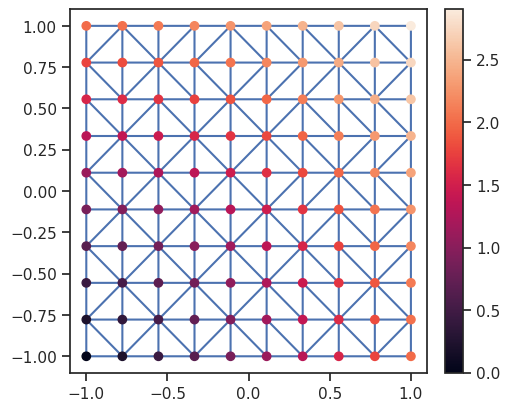

In [9]:
fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
ax.triplot(vertices[:, 0], vertices[:, 1], simplices)
scatter_plot = ax.scatter(vertices[:, 0], vertices[:, 1], c=solution.values)
plt.colorbar(scatter_plot)
# for i, vertex in enumerate(vertices):
#     ax.annotate(i, (vertex[0], vertex[1]))
# for i, simplex in enumerate(simplices):
#     centroid = jnp.mean(vertices[simplex], axis=0)
#     ax.annotate(i, (centroid[0], centroid[1]))